# Testing $\nu$ model

Making use of the available effective area to get started.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

## Read in the data

$A_{\rm{eff}}$ = $A_{\rm{eff}}(\omega, E)$

In [2]:
# effective area
filename = '../data/3year-data-release/IC79-2010-TabulatedAeff.txt'
filelayout = ['Emin', 'Emax', 'cos(z)min', 'cos(z)max', 'Aeff']
output = pd.read_csv(filename, comment = '#',
                     delim_whitespace = True,
                     names = filelayout)

output_dict = output.to_dict()
Emin = list(output_dict['Emin'].values())
Emax = list(output_dict['Emax'].values())
coszmin = list(output_dict['cos(z)min'].values())
coszmax = list(output_dict['cos(z)max'].values())
Aeff = list(output_dict['Aeff'].values())

# find bin centres
Emin = np.sort(list(set(Emin)))
Emax = np.sort(list(set(Emax)))
Ec = (Emin + Emax)/2

coszmin = np.sort(list(set(coszmin)))
coszmax = np.sort(list(set(coszmax)))
coszc = (coszmin + coszmax)/2

/Users/fran/projects/bayes/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


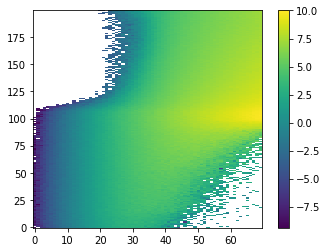

In [3]:
# sort into grid
# compare with plots in IceCube data release
A = np.transpose(np.reshape(Aeff, (70, 200)))
plt.imshow(np.log(A), origin = 'lower', aspect = 1/3)
plt.colorbar()
A = np.transpose(A)

## Interpolation/smoothing

In [4]:
from scipy import interpolate
from scipy import ndimage
sigma = [0.001, 5]
As = ndimage.filters.gaussian_filter(A, sigma, mode='constant')
effective_area = interpolate.RectBivariateSpline(Ec, coszc, A, s=0.0)
effective_area_smooth = interpolate.RectBivariateSpline(Ec, coszc, As, s=0.0)
norm = A.max()

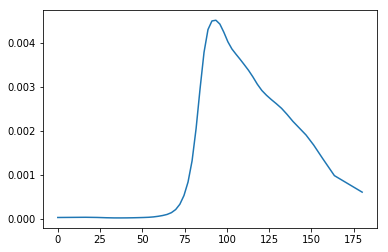

In [5]:
#m = []
m_smooth = []
cosz = np.linspace(-1, 1)
Etest = 1e5
for c in cosz:
    #m.append(effective_area(Etest, c)[0] / norm)
    m_smooth.append(effective_area_smooth(Etest, c)[0] / norm)

    
z = np.rad2deg(np.arccos(cosz)) 
#plt.plot(z, m)
plt.plot(z, m_smooth)

In [6]:
def m(z):
    """
    Interpolation to return projection factor.
    
    NB: in the spherical coordinate system, southern zenith = np.pi - theta
    """
    selected_E = 1e5 # GeV
    cosz = np.cos(z)
    return effective_area_smooth(selected_E, cosz)[0] / norm

In [7]:
# testing
from neutrino_ideas import m_integrand
from scipy import integrate

integ, err = integrate.quad(m_integrand, 0, np.pi, args = (m))
print('M = ', integ, '+/-', err)
print('M / 4pi = ', integ / (4 * np.pi))
M = integ

M =  0.022912642456839712 +/- 1.1704243559327997e-08
M / 4pi =  0.0018233301531516348


In [8]:
# Aeff_smooth = np.zeros((70, 200))
# Aeff = np.zeros((70, 200))
# Ec = np.logspace(np.log(100), np.log(1e9), 70, base = np.e)
# cosz = np.linspace(-1, 1, 200)

# for i, e in enumerate(Ec):
#    for j, c in enumerate(cosz):
#        Aeff_smooth[i][j] = effective_area_smooth(e, c)
#        Aeff[i][j] = effective_area(e, c)

In [9]:
#plt.imshow(np.log(np.transpose(Aeff_smooth) / Aeff_smooth.max()), 
#           origin = 'lower', aspect = 1/3, vmin = -18)
#plt.colorbar()

## Select a representative E

$A_{\rm{eff}} = A_{\rm{eff}}(\omega)$ for a certain E 

Deal with the full problem later....

In [10]:
import sys
sys.path.append('../../fancy')
from fancy.plotting import AllSkyMap
import vapeplot
from matplotlib.colors import Normalize
from astropy.coordinates import SkyCoord
from astropy import units as u

/Users/fran/projects/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/fran/projects/bayes/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [11]:
selected_E = 1e5 # GeV

may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).

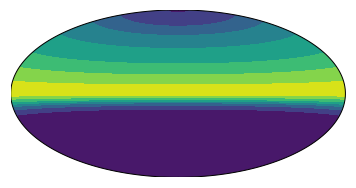

In [12]:
# plot on skymap
# theta = np.pi/2 + dec
num_points = 50
declinations = np.linspace(-90, 90, num_points)
rightascensions = np.linspace(-180, 180, num_points)

for d in declinations:
    Aeff = np.array([
        (effective_area_smooth(selected_E, np.cos(np.pi/2 + np.deg2rad(d)))[0] / norm)[0] 
        for d in declinations])
Aeff = [Aeff for ra in rightascensions]

dec, ra = np.meshgrid(declinations, rightascensions)

skymap = AllSkyMap(projection = 'hammer', lon_0 = 0, lat_0 = 0);
skymap.contourf(ra, dec, Aeff, latlon = True)

## Simple catalogue

In [13]:
# choose a set of sources and compute exposure integrals 
from fancy import Data
#source_file = '../../uhecr_model_dev/data/sourcedata.hdf5'
source_file = 'data/toy_cosmo_pop.h5'

data = Data()
data.add_source(source_file, 'cosmo_1000')

may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).WARNING:Error plotting coords [199.72761472582988 87.78963555461581] with radius 3


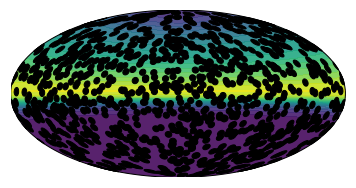

In [14]:
sra = data.source.coord.icrs.ra.rad
sdec = data.source.coord.icrs.dec.rad

skymap = AllSkyMap(projection = 'hammer', lon_0 = 0, lat_0 = 0);
skymap.contourf(ra, dec, Aeff, 20, latlon = True, alpha = 0.9)
for sr, sd in zip(sra, sdec):
    skymap.tissot(np.rad2deg(sr), np.rad2deg(sd), 3, 30, color = 'k')

(array([109., 176., 149., 117., 110.,  86.,  83.,  68.,  53.,  49.]),
 array([  718.04520196,  5421.0323269 , 10124.01945184, 14827.00657679,
        19529.99370173, 24232.98082667, 28935.96795161, 33638.95507655,
        38341.94220149, 43044.92932643, 47747.91645137]),
 <a list of 10 Patch objects>)

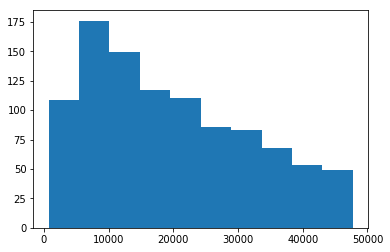

In [15]:
plt.hist(data.source.distance)

In [18]:
# precompute exposure integrals
from scipy import integrate
from neutrino_ideas import m_integrand, bg_integrand

# choose observatory parameters
A_IC = norm # km^2
T = 1 # year
eps = []

# sources
for varpi in data.source.unit_vector:
    # get zenith of position
    zenith = np.pi - np.arccos( varpi[2] )
    mu = m(zenith)[0]
    eps.append(A_IC * T * mu)   
    
# background
eps.append(A_IC * T * (M / (4 * np.pi)))

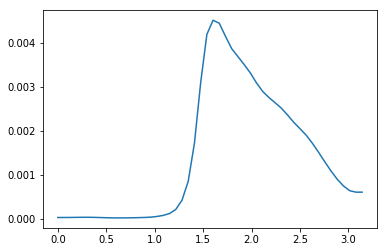

In [19]:
# make interpolation grid to do selection
zenith_grid = np.linspace(0, np.pi)
m_grid = [m(z)[0] for z in zenith_grid]
plt.plot(zenith_grid, m_grid)

## Stan simulation

Simulate with all sources in the population.

In [20]:
import stan_utility
sim = stan_utility.compile_model(filename = 'test_nu_sim.stan', model_name = 'neutrino_sim')

Using cached StanModel


In [21]:
# prepare inputs
Nsim = 100000 # before exposure effects
#FT = Nsim / eps[-1]  # assuming T = 1yr (fix later)
alpha_T = eps[-1] * 4 * np.pi
FT = (Nsim * M) / alpha_T # km^-2 yr^-1
f = 0.5

D = data.source.distance
Mpc_to_km = 3.086E19
L = ( (f * FT) / (sum([1 / (4 * np.pi * (d * Mpc_to_km)**2) for d in D])) )  # yr^-1
F0 = (1 - f) * FT # km^-2 yr^-1
kappa = 200

# standard candle
print('F_T: ', FT)
print('F_s: ', f * FT)
print('L: ', L)
print('F_0: ', F0)

F_T:  4.484304932735426
F_s:  2.242152466367713
L:  1.0200302704329538e+45
F_0:  2.242152466367713


In [22]:
sim_input = {'Ns' : data.source.N,
             'varpi' : data.source.unit_vector,
             'D' : data.source.distance,
             'kappa' : kappa,
             'L' : L,
             'F0' : F0,
             'eps' : eps,
             'Ngrid' : len(m_grid),
             'm_grid' : m_grid,
             'zenith_grid' : zenith_grid}

simulation = sim.sampling(data = sim_input, iter =1, chains = 1, algorithm = "Fixed_param")

In [23]:
from fancy.interfaces.stan import Direction
event = simulation.extract(['event'])['event'][0]
#lam = simulation.extract(['lambda'])['lambda'][0]
event = Direction(event)
era = event.d.icrs.ra.rad
edec = event.d.icrs.dec.rad

may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).WARNING:Error plotting coords [199.72761472582988 87.78963555461581] with radius 3


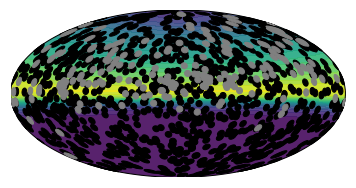

In [24]:
sra = data.source.coord.icrs.ra.rad
sdec = data.source.coord.icrs.dec.rad

skymap = AllSkyMap(projection = 'hammer', lon_0 = 0, lat_0 = 0);
skymap.contourf(ra, dec, Aeff, 20, latlon = True, alpha = 0.9)
for sr, sd in zip(sra, sdec):
    skymap.tissot(np.rad2deg(sr), np.rad2deg(sd), 3, 30, color = 'k')
for er, ed in zip(era, edec):
    skymap.tissot(np.rad2deg(er), np.rad2deg(ed), 3, 30, color = 'grey')

## Stan fit

Fit only with sources within a certain $D_\rm{th}$.

In [25]:
from popsynth.cosmological_population import luminosity_distance
luminosity_distance(1.5) / 3.086E24

11121.142228219536

In [26]:
#Dth = 2E4
Dth = 10000 # z~1.4
data.source.select_distance(Dth)
data.source.N
s = data.source.selection

eps0 = eps[-1]
eps = [eps[i] for i in s]
eps.append(eps0)

No fluxes to select on.


In [27]:
# prepare fit inputs
fit_input = {'N' : len(event.unit_vector), 
             'omega_det' : event.unit_vector, 
             'Ns' : data.source.N, 
             'varpi' : data.source.unit_vector,
             'D' : data.source.distance,
             'eps' : eps,
             'A_IC' : norm,
             'Ngrid' : len(m_grid),
             'm_grid' : m_grid,
             'zenith_grid' : zenith_grid}

In [28]:
fit_input['N']

190

In [29]:
model = stan_utility.compile_model(filename = 'test_nu_model.stan', model_name = 'neutrino_model')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL neutrino_model_0abebac4aea7f05952f5911e6daf410e NOW.


In [555]:
fit = model.sampling(data = fit_input, iter = 1000, chains = 4, seed = 19920715)

In [556]:
stan_utility.utils.check_treedepth(fit)
stan_utility.utils.check_div(fit)
stan_utility.utils.check_energy(fit)
#print (fit)

0 of 2000 iterations saturated the maximum tree depth of 10 (0.0%)
0.0 of 2000 iterations ended with a divergence (0.0%)
E-BFMI indicated no pathological behavior


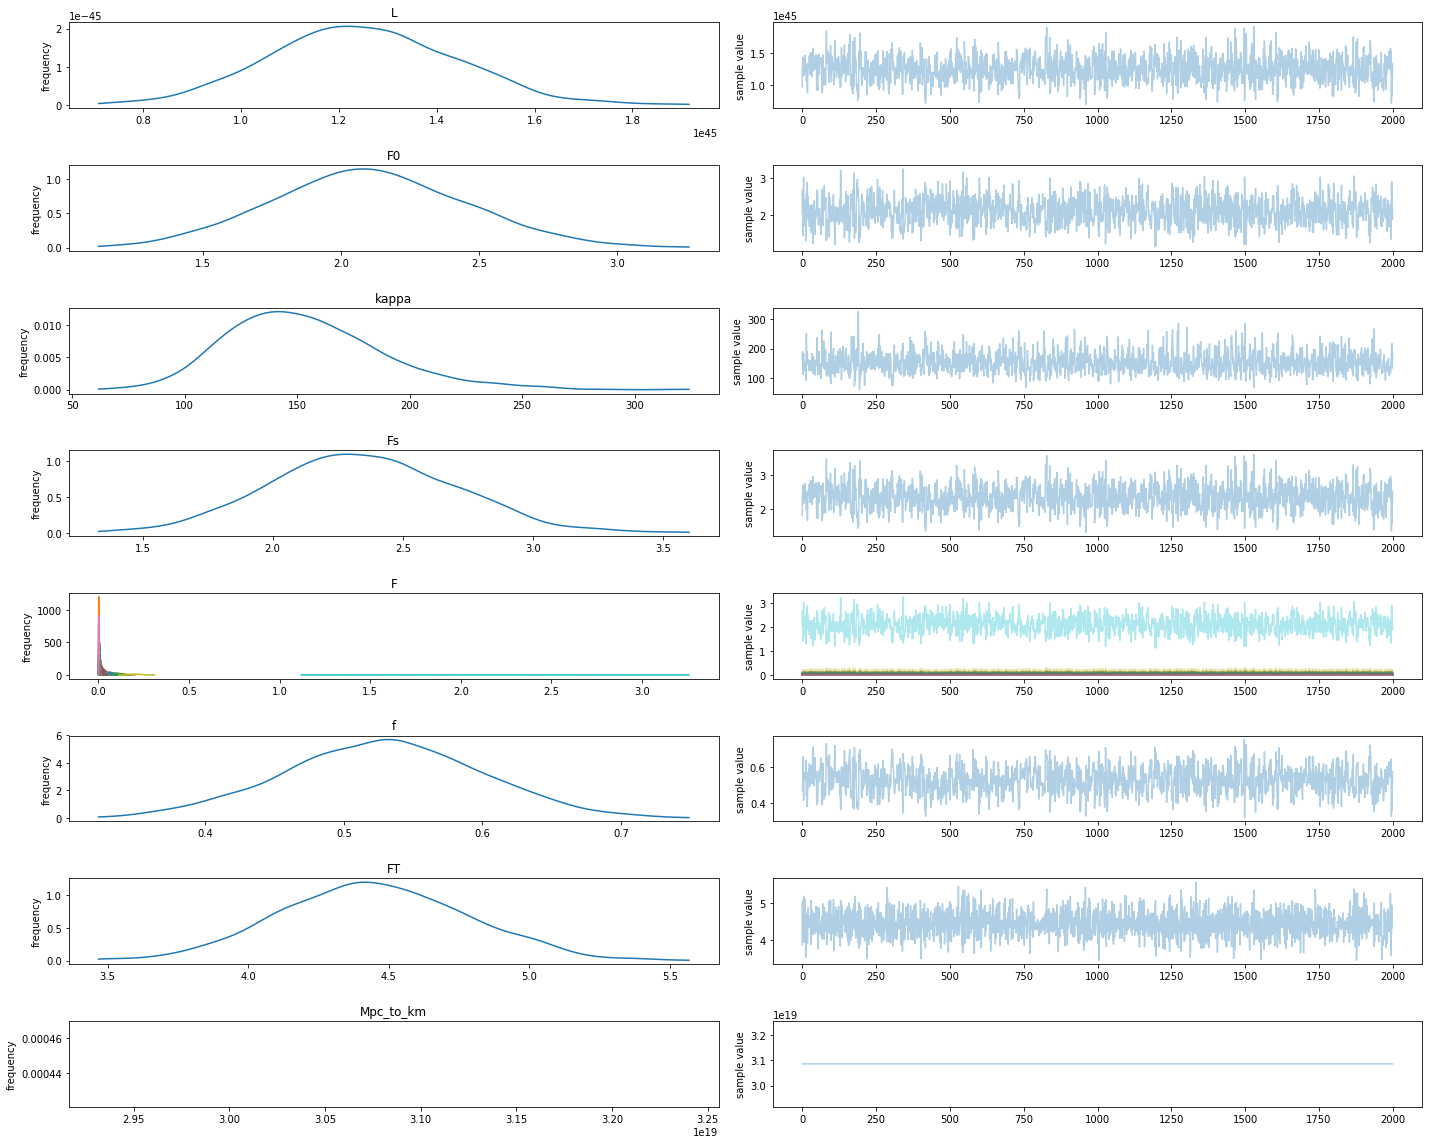

In [557]:
fig = fit.plot();
fig.set_size_inches(20, 16)
fig.tight_layout()

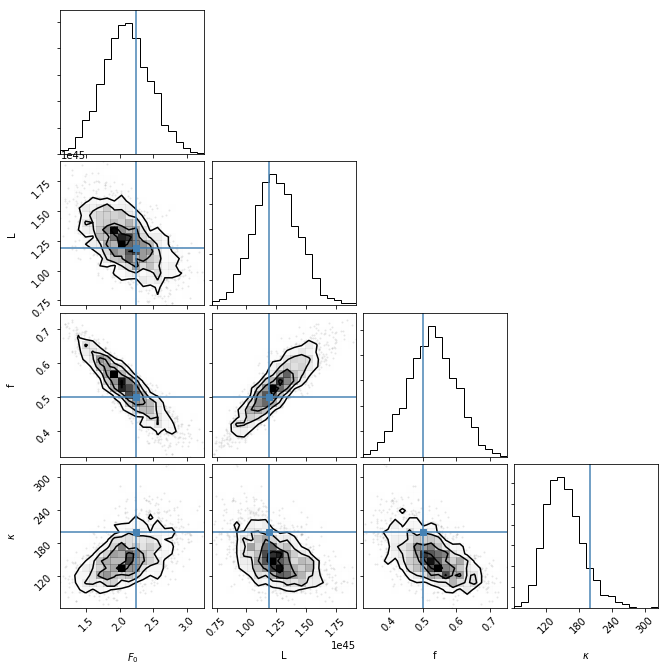

In [558]:
import corner
chain = fit.extract(permuted = True)
key_list = ['F0', 'L', 'f', 'kappa']
labels = [r'$F_0$', r'L', 'f', r'$\kappa$']
truths = [F0 , L , f, kappa]

corner.corner(np.nan_to_num(np.column_stack([chain[key] for key in key_list])),
              labels = labels, 
              truths = truths);

## To do 
 
* Clean up code into package
* Check observation period times
* Fix units
* Try to add in energy